In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt

## The Simple Compartmental Model SEIRD
S - Susceptible
E - Exposed
I - Infectious
R - Recovered
D - Dead

In [30]:

# the SEIR model differential equations
def deriv(t, y, N, beta, sigma, gamma, delta):
    S, E, I, R, D = y
    dSdt = -beta * S * I / (N-D)
    dEdt = beta * S * I / (N-D) - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [53]:
# theotal population we are modeling -  N
N = 1000
# the initial number of infected and recovered individuals in our data
I0, R0 = 1, 0
# the initial number of exposed individuals in our data
E0 = 0
# the initial number of folk dead from the disease is zero
D0 = 0
# everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0 - E0 - D0
# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta, sigma, gamma, delta = 0.3, 1/5.2, 1/10, 1/150
# the time points (days) over which we want to predict using our model
t = np.linspace(0, 80, 5)

# here we set the initial conditions vector
y0 = S0, E0, I0, R0, D0

In [54]:

# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 160], y0, args=(N, beta, sigma, gamma, delta), t_eval=t)

# extract the results
S, E, I, R, D = sol.y

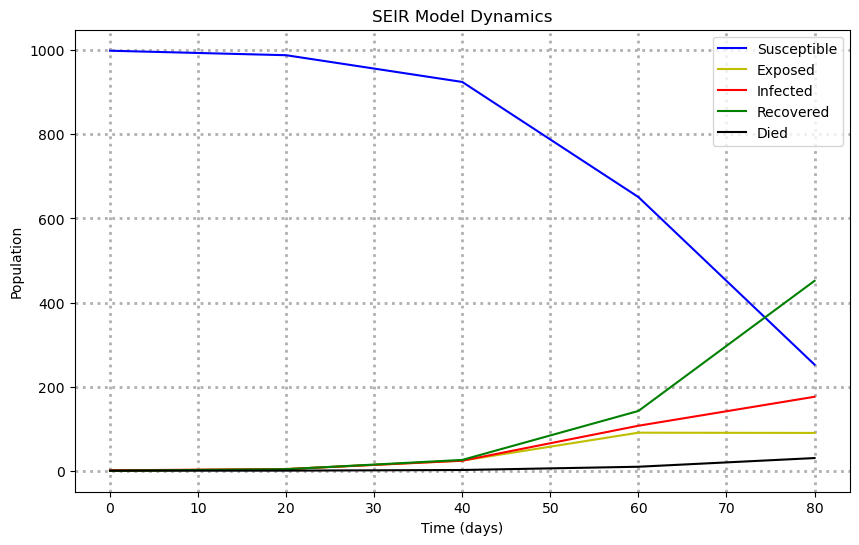

In [55]:
# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(10,6))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, E, 'y', label='Exposed')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.plot(t, D, 'k', label='Died')
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")
plt.show()

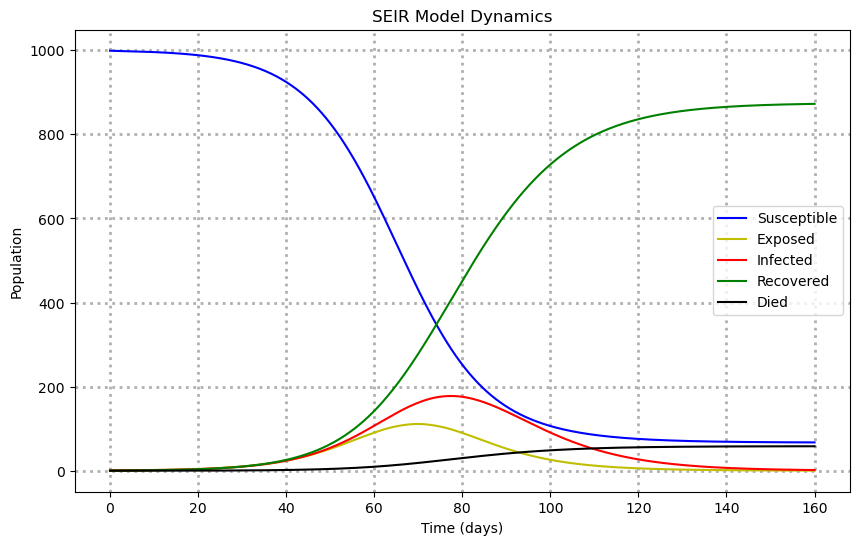

In [34]:

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(10,6))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, E, 'y', label='Exposed')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.plot(t, D, 'k', label='Died')
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")
plt.show()

## Adding age compartments

To start simple, doing just two coupled groups. Given we want to look at ages, we call them "young" and "old", for now. 

And, for now, we shall have a constant coupling parameter $\theta$ between their infected boxes. $\theta$ represents the relative likelihood of meeting someone from the opposite group. It is like a perturbation to beta. We assume $|\theta| ~ 1$. Small theta implies that the groups are less likely to mix. $\theta << 1$ gives 

In [7]:
# the SEIR model differential equations
def deriv(t, Y, N_y, N_o, beta_ybox, beta_obox, sigma, gamma, delta, theta_yo, theta_oy):
    Y_y , Y_o = Y.reshape(2,5)
    S_y, E_y, I_y, R_y, D_y = Y_y
    S_o, E_o, I_o, R_o, D_o = Y_o

    Y_ybox = (1.0 - theta_yo)*Y_y + theta_oy*Y_o
    Y_obox = (1.0 - theta_oy)*Y_o + theta_yo*Y_y

    N_ybox = (1.0 - theta_yo)*(N_y-D_y) - theta_oy * (N_o - D_o)
    N_obox = (1.0 - theta_oy)*(N_o-D_o) - theta_yo * (N_y - D_y)
    
    S_ybox, E_ybox, I_ybox, R_ybox, D_ybox = Y_ybox
    S_obox, E_obox, I_obox, R_obox, D_obox = Y_obox
    
    dS_ydt = -beta_ybox*S_y*(1-theta_yo)*I_ybox / N_ybox  - beta_obox * theta_yo*S_y * I_obox / N_obox
    dS_odt = -beta_obox*S_o*(1-theta_oy)*I_obox / N_obox  - beta_ybox * theta_oy*S_o * I_ybox / N_ybox
    
    dE_ydt = -dS_ydt - sigma * E_y
    dE_odt = -dS_odt - sigma * E_o

    dI_ydt = sigma * E_y - (gamma + delta) * I_y
    dI_odt = sigma * E_o - (gamma + delta) * I_o
    
    dR_ydt = gamma * I_y
    dR_odt = gamma * I_o
    
    dD_ydt = delta * I_y
    dD_odt = delta * I_o

    dY_ydt = [dS_ydt, dE_ydt, dI_ydt, dR_ydt, dD_ydt]
    dY_odt = [dS_odt, dE_odt, dI_odt, dR_odt, dD_odt]

    
    return np.array([dY_ydt, dY_odt]).flatten()

In [8]:
# theotal population we are modeling -  N
N_y , N_o = 1000, 1000
# the initial number of infected and recovered individuals in our data
I_y0, R_y0, I_o0, R_o0 = 1, 0, 1, 0
# the initial number of exposed individuals in our data
E_y0, E_o0 = 0, 0
# the initial number of folk dead from the disease is zero
D_y0, D_o0 = 0, 0
# everyone else, S0, is susceptible to infection initially
S_y0 = N_y - I_y0 - R_y0 - E_y0 - D_y0
S_o0 = N_o - I_o0 - R_o0 - E_o0 - D_o0

# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_ybox, beta_obox = 0.3, 0.2

sigma, gamma, delta = 1.0, 0.1, 0.01

# the coupling rate between the boxes. 
theta_yo , theta_oy = 0.00, 0.00

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 200, 800)

# here we set the initial conditions vector
Y_y0 = S_y0, E_y0, I_y0, R_y0, D_y0
Y_o0 = S_o0, E_o0, I_o0, R_o0, D_o0

Y0 = np.array([Y_y0, Y_o0]).reshape(10)

print("Starting vector = ",Y0)
print("Parameters:\n beta_ybox = {},\n beta_obox = {},\n sigma = {},\n gamma = {},\n delta = {},\n theta_yo = {},\n theta_oy = {},\n".format(beta_ybox,
                                                                                                                                             beta_obox,
                                                                                                                      sigma,
                                                                                                                      gamma,
                                                                                                                      delta,
                                                                                                                      theta_yo,
                                                                                                                      theta_oy))

Starting vector =  [999   0   1   0   0 999   0   1   0   0]
Parameters:
 beta_ybox = 0.3,
 beta_obox = 0.2,
 sigma = 1.0,
 gamma = 0.1,
 delta = 0.01,
 theta_yo = 0.0,
 theta_oy = 0.0,



In [9]:
# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 200], Y0, args=(N_y, N_o, beta_ybox, beta_obox, sigma, gamma, delta, theta_yo, theta_oy), t_eval=t)

# extract the results
Y_yt, Y_ot = sol.y.reshape(2,5,len(t))

S_yt, E_yt, I_yt, R_yt, D_yt = Y_yt
S_ot, E_ot, I_ot, R_ot, D_ot = Y_ot

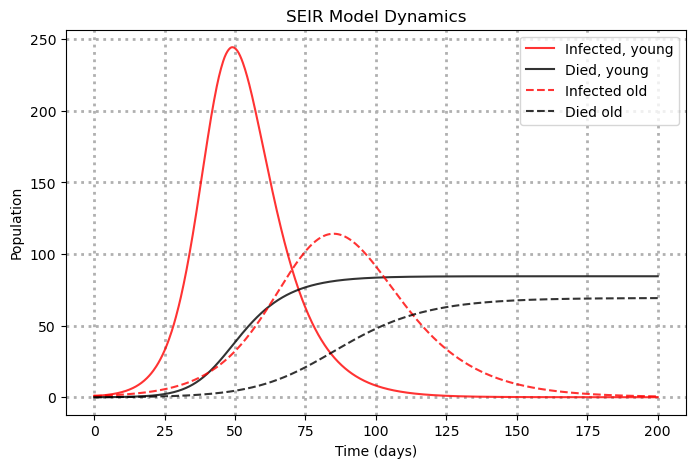

In [10]:
S_plot, E_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(8,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, E_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

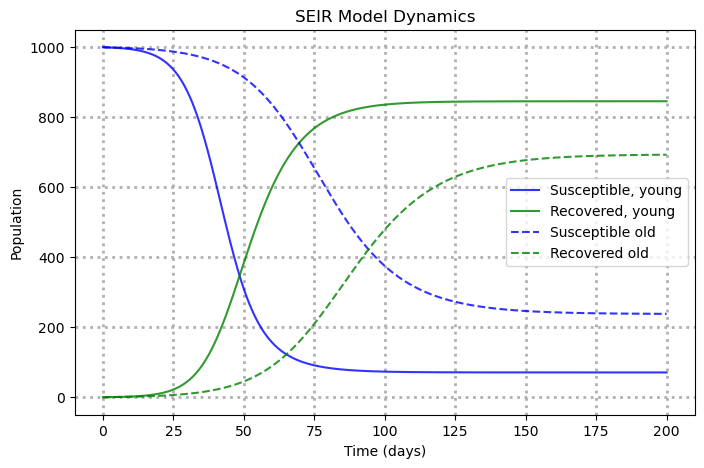

In [11]:
S_plot, E_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(8,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, E_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, E_plot, 'y', label='Exposed')
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

# SIRD just for ease. 

In [12]:
# the SEIR model differential equations
def deriv(t, Y, N_y, N_o, beta_ybox, beta_obox, gamma, delta, theta_yo, theta_oy):
    Y_y , Y_o = Y.reshape(2,4)
    S_y, I_y, R_y, D_y = Y_y
    S_o, I_o, R_o, D_o = Y_o

    N_ybox = (1.0 - theta_yo)*(S_y + I_y + R_y) + theta_oy * (S_o + I_o + R_o)
    N_obox = (1.0 - theta_oy)*(S_o + I_o + R_o) + theta_yo * (S_y + I_y + R_y)

    I_ybox = (1.0 - theta_yo)*I_y + theta_oy*I_o
    I_obox = (1.0 - theta_oy)*I_o + theta_yo*I_y

    S_y_in_ybox = S_y*(1-theta_yo)
    S_o_in_obox = S_o*(1-theta_oy)
    S_y_in_obox = S_y * theta_yo
    S_o_in_ybox = S_o * theta_oy
    
    dS_ydt = -beta_ybox*S_y_in_ybox*I_ybox / N_ybox  - beta_obox * S_y_in_obox * I_obox / N_obox
    dS_odt = -beta_obox*S_o_in_obox*I_obox / N_obox  - beta_ybox * S_o_in_ybox * I_ybox / N_ybox
    
    dI_ydt = -dS_ydt - (gamma + delta) * I_y
    dI_odt = -dS_odt - (gamma + delta) * I_o
    
    dR_ydt = gamma * I_y
    dR_odt = gamma * I_o
    
    dD_ydt = delta * I_y
    dD_odt = delta * I_o

    dY_ydt = [dS_ydt, dI_ydt, dR_ydt, dD_ydt]
    dY_odt = [dS_odt, dI_odt, dR_odt, dD_odt]

    
    return np.array([dY_ydt, dY_odt]).flatten()

In [13]:
# theotal population we are modeling -  N
N_y , N_o = 1000, 1000
# the initial number of infected and recovered individuals in our data
I_y0, R_y0, I_o0, R_o0 = 1, 0, 0, 0
# the initial number of folk dead from the disease is zero
D_y0, D_o0 = 0, 0
# everyone else, S0, is susceptible to infection initially
S_y0 = N_y - I_y0 - R_y0 - D_y0
S_o0 = N_o - I_o0 - R_o0 - D_o0

# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_ybox, beta_obox = 0.2, 0.1

gamma, delta = 0.1, 0.01

# the coupling rate between the boxes. 
theta_yo , theta_oy = 0.0, 0.1

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

# here we set the initial conditions vector
Y_y0 = S_y0, I_y0, R_y0, D_y0
Y_o0 = S_o0, I_o0, R_o0, D_o0

Y0 = np.array([Y_y0, Y_o0]).reshape(8)

print("Starting vector = ",Y0)
print("Parameters:\n beta_ybox = {},\n beta_obox = {},\n gamma = {},\n delta = {},\n theta_yo = {},\n theta_oy = {},\n".format(beta_ybox,
                                                                                                                                             beta_obox,
                                                                                                                      gamma,
                                                                                                                      delta,
                                                                                                                      theta_yo,
                                                                                                                      theta_oy))

Starting vector =  [ 999    1    0    0 1000    0    0    0]
Parameters:
 beta_ybox = 0.2,
 beta_obox = 0.1,
 gamma = 0.1,
 delta = 0.01,
 theta_yo = 0.0,
 theta_oy = 0.1,



In [14]:
# Now we use scipy to solve the system of differential equations
sol = solve_ivp(deriv, [0, 400], Y0, args=(N_y, N_o, beta_ybox, beta_obox, gamma, delta, theta_yo, theta_oy), t_eval=t)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.001e-02 ...  3.999e+02  4.000e+02]
        y: [[ 9.990e+02  9.990e+02 ...  2.708e+02  2.708e+02]
            [ 1.000e+00  1.004e+00 ...  1.486e-04  1.483e-04]
            ...
            [ 0.000e+00  2.275e-06 ...  3.055e+02  3.055e+02]
            [ 0.000e+00  2.275e-07 ...  3.055e+01  3.055e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 140
     njev: 0
      nlu: 0

In [15]:
# extract the results
Y_yt, Y_ot = sol.y.reshape(2,4,len(t))

S_yt, I_yt, R_yt, D_yt = Y_yt
S_ot, I_ot, R_ot, D_ot = Y_ot

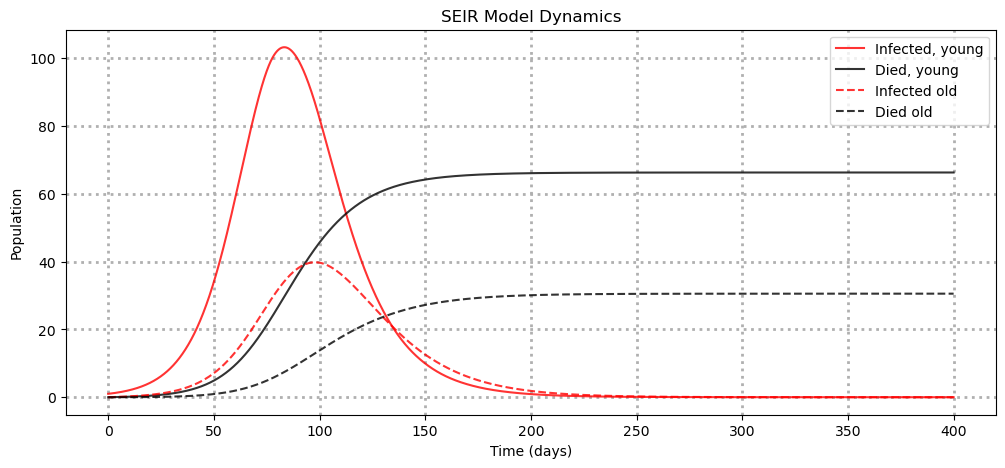

In [16]:
S_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

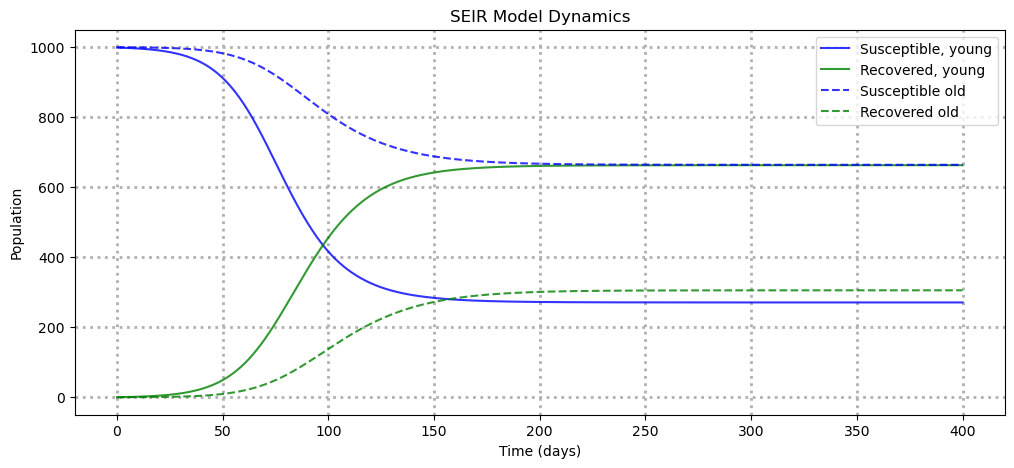

In [17]:
S_plot, I_plot, R_plot, D_plot = Y_yt

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

S_plot, I_plot, R_plot, D_plot = Y_ot

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

## Observations:

1) It seems that the only way of reducing the overall number of deaths in a category is to reduce the infectiousness $\beta$ for that compartment. If that happens, the overall number of dead in the limit of large $t$ is lower (although there is a larger number of susceptible left at the end).

2) If the coupling $\theta$ is very small, then having different infectivities $\beta$ for each environment is relevant. However, the larger $\theta$ is, the less different $\beta$ values matter. As expected, $\theta = 0$ gives completely decoupled populations, and $\theta = 0.5$ gives perfectly mixed populations. $\theta > 0.5$ has an interesting swapover, where the "old" population spend most of their time in a high$\beta$ environment, and thus actually die more.

3) It ultimately works on the idea that the disease dies out before the entire population is infected due to herd immunity. If the whole population gets infected, then the total number of deaths will be the same in the long run.

4) Theta does not need to be symmetric, i.e. the outcome when $\theta_{yo}$ and $\theta_{oy}$ are switched is not the same. Indeed if $\beta$ is not the same for both populations, then $\theta$ being switched changes the curves significantly. 

# Generalized multi-population SIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population $i$ is stored in the Y matrix: $Y^{i}_{c}$, where $i$ is the population (stored in rows), and $c$ is the category ($S^i$, $I^i$, $R^i$ or $D^i$). Thus, in this case $Y$ is an $N$ by 4 matrix, where $N$ is the number of different populations. 




The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^j_i$, each element of which has the proportion of population $j$ that spend that timestep in the environment of population $i$. It can also be thought of as the probability that a person from population $i$ will spend time in the environment of population $j$. $\sum_{j} \theta^j_i = 1$. 

$$ \sum_{i} \theta^j_i ~ Y^{i}_{c} = B^{j}_{c}, $$

where $B^j_c$ is an $N$ by 4 matrix of the number of people in environment $j$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, infectious, recovered, or dead). 


The number of new infections in a particular group $i$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those staying} &= \text{\# susceptible who stay} \times \beta_i \times \frac{\text{\# infectious in }i}{\text{total \# in }i}, \\
&= S_i\left(1 - \sum_{j\neq i}\theta^j_i \right) \times \beta_i \times \frac{B^i_{\text{infectious}}}{B^i_{\text{susceptible}} + B^i_{\text{infectious}} + B^i_{\text{recovered}}}.
\end{align}

Similarly, the number of infections gained elsewhere can be calculated:
\begin{align}
\text{New Infections for those of type }i\text{ visiting other places} &= \sum_{\text{places visited} j}\text{\# susceptible who went} \times \beta_i \times \frac{\text{\# infectious in }j}{\text{total \# in }j}, \\
&= \sum_{j\neq i} S_i \theta^j_i \times \beta_j \times \frac{B^j_{\text{infectious}}}{B^j_{\text{susceptible}} + B^j_{\text{infectious}} + B^j_{\text{recovered}}}.
\end{align}


A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. 





In [18]:
test_matrix = np.array([[0.9,0.01,0.08,0.01],[1.0,0.0,0.0,0.0]])
test_matrix[:,0] + test_matrix[:,1]

array([0.91, 1.  ])

In [58]:
# the SEIR model differential equations
def deriv_matrix(t, # irrelevant as t is not used explicitly 
                 Y: npt.NDArray, 
                 beta_vector: npt.ArrayLike,
                 gamma: float, 
                 delta: float,
                 theta_matrix: npt.NDArray) -> np.array:
    """
    Takes the parameters and state matrix $Y$ and computes the derivative dYdt

    Args:
      Y (np.array): 
        The state matrix. This says the population in each compartment (S,I,R, and D), 
        for each type of population (e.g. old, young). Should be input as a flattened matrix.  
      beta_vector (np.array/list):
        The infection coefficient for each population's environment. Units of /day
        [beta_1, beta_2, ..., beta_n] where n is the number of types of population (e.g. young, old).
      gamma (float):
        the recovery rate in /day
      delta (float):
        the death rate in /day
      theta_matrix (npt.NDArray):
        NxN matrix, where N is the number of types of population. 
        The matrix encodes the portion of people of type i who visit environment j in the timestep. 
        can be thought of as a probability. Probability is independent of the compartment state (S,I,and R all visit),
        Dead folk don't visit. 

    Returns:
      dYdt (np.array): 
        A flattened array of the same dimensions as Y, corresponding to dY/dt (the change in Y for 1 day). 
    """
    Y_matrix = Y.reshape(len(beta_vector), 4)

    S, I, R, D = Y_matrix.T
    
    B_env_matrix = np.matmul(theta_matrix, Y_matrix)

    S_env, I_env, R_env, D_env = B_env_matrix.T
    
    N_active_env = S_env + I_env + R_env  # just adds S, I, and R

    # The vulnerable matrix ---- says which
    
    dYdt = np.zeros(Y_matrix.shape)
    
    new_infections_by_pop = np.zeros(len(S))
    
    #for i, s_i in enumerate(S):
    #    new_infections_by_pop[i] = np.matmul(s_i * theta_matrix.T[i] , beta_vector * I_env / N_active_env)
    new_infections_by_pop = np.matmul( np.multiply(S, theta_matrix).T , beta_vector * I_env / N_active_env)
    
    dYdt = np.array([-new_infections_by_pop, 
                     new_infections_by_pop - I*(gamma+delta), 
                     gamma*I,  
                     delta*I]).T

    return dYdt.flatten()

In [59]:
def simple_error_checks(Y_matrix_0, N_vector, beta_vector, gamma, delta, theta_matrix):
    if not Y_matrix_0.shape == (len(N_vector), 4):
        raise Exception("Y_matrix_0 is not the right shape for N_vector")
    if not len(beta_vector) == Y_matrix_0.shape[0]:
        raise Exception("beta vector is not the same length as Y_matrix_0 (the number of pops)")
    if not theta_matrix.shape == (len(beta_vector), len(beta_vector)):
        raise Exception("theta_matrix is not N by N, where N is the length of the beta_vector and the number of populations")
    if not np.array_equal(theta_matrix.sum(axis=0), np.ones(len(beta_vector))):
        raise Exception("the theta_matrix isn't properly normalized (all columns should add to one)")

In [133]:
Y_matrix_0 = np.array([[999, 1, 0, 0],
                       [500, 0, 0, 0]])


N_vector = Y_matrix_0.sum(axis=1)

# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_vector = np.array([0.2, 0.1])

gamma, delta = 0.1, 0.01

# the coupling matrix between the boxes. 
theta_matrix = np.array([[1.0-0.1, 0.1],
                         [0.1, 1-0.1]])

print("Number of populations = {}\n".format(len(beta_vector)))
print(" Starting vector = \n",Y_matrix_0)

print("\nParameters:\n beta_vector = ",beta_vector)
print(" gamma = {},\n delta = {},\n".format(gamma, delta))
print(" theta_matrix = \n",theta_matrix)

# Do some simple error checks
simple_error_checks(Y_matrix_0, N_vector, beta_vector, gamma, delta, theta_matrix)

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

print("\n\nReady to go!")

Number of populations = 2

 Starting vector = 
 [[999   1   0   0]
 [500   0   0   0]]

Parameters:
 beta_vector =  [0.2 0.1]
 gamma = 0.1,
 delta = 0.01,

 theta_matrix = 
 [[0.9 0.1]
 [0.1 0.9]]


Ready to go!


In [134]:
# Now we use scipy to solve the system of differential equations
solmat = solve_ivp(deriv_matrix, 
                   [0, 400], 
                   Y_matrix_0.flatten(), 
                   args=(beta_vector, gamma, delta, theta_matrix), 
                   t_eval=t)

solmat

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.001e-02 ...  3.999e+02  4.000e+02]
        y: [[ 9.990e+02  9.990e+02 ...  3.034e+02  3.034e+02]
            [ 1.000e+00  1.003e+00 ...  1.289e-04  1.286e-04]
            ...
            [ 0.000e+00  2.208e-06 ...  1.801e+02  1.801e+02]
            [ 0.000e+00  2.208e-07 ...  1.801e+01  1.801e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 152
     njev: 0
      nlu: 0

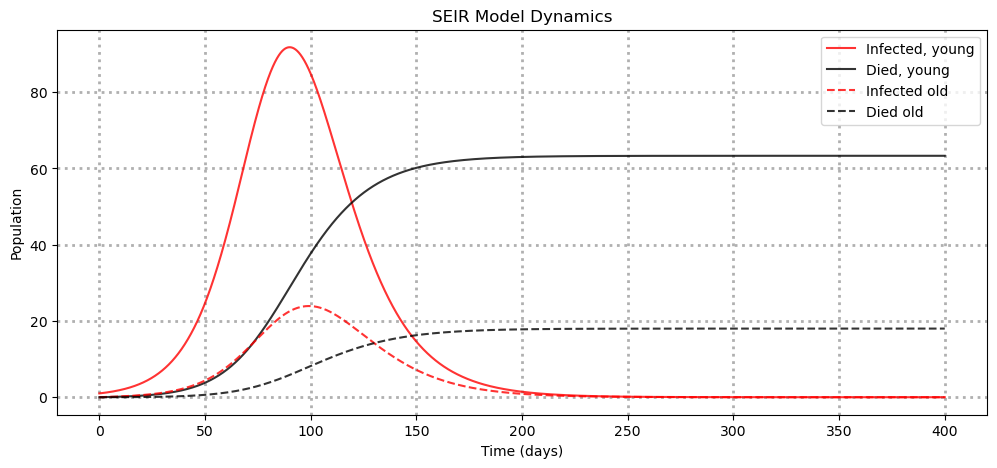

In [135]:
Y_t = solmat.y.reshape(2,4,len(t))

S_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

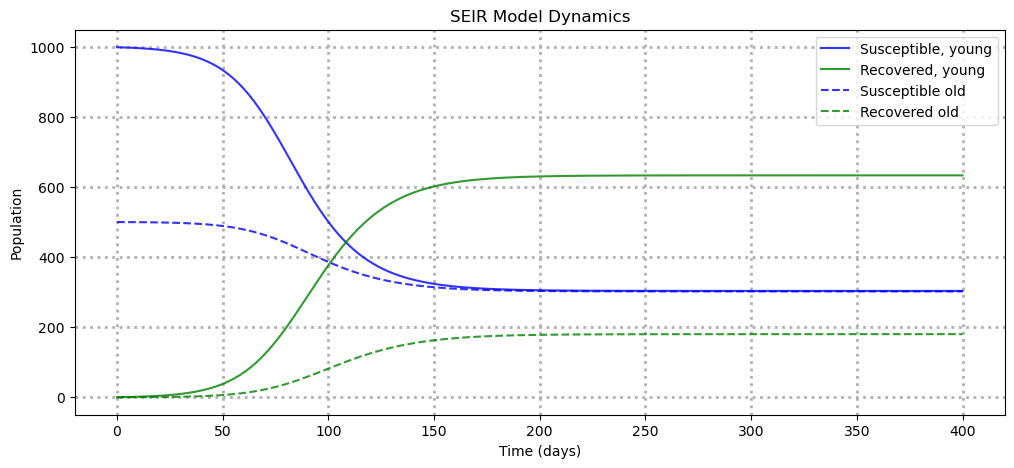

In [136]:
Y_t = solmat.y.reshape(2,4,len(t))

S_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
#plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
#plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
#plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
#plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

Generate some sparse data with a little noise

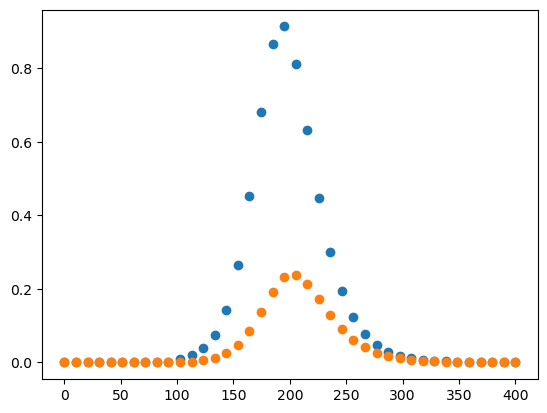

In [137]:
t_sparse = np.linspace(0,400, 40)
solmat_fake = solve_ivp(deriv_matrix, 
                   [0, 400], 
                   Y_matrix_0.flatten(), 
                   args=(beta_vector, gamma, delta, theta_matrix), 
                   t_eval=t_sparse)


Y_sparse = solmat_fake.y.reshape(2,4,len(t_sparse)).transpose((2,0,1))
my_sparse_derivs = np.zeros(Y_sparse.shape)
for i,yt in enumerate(Y_sparse):
    my_sparse_derivs[i] = deriv_matrix(t,
                                yt.flatten(),
                                beta_vector,
                                gamma,
                                delta,
                                theta_matrix).reshape(yt.shape)

fake_deaths_per_day = my_sparse_derivs.T[3]


shifted_fake_deaths_per_day = np.concatenate([np.zeros((2,10)), fake_deaths_per_day[:,0:30]],axis=1)
shifted_fake_deaths_per_day.shape
plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], label='Sparse Young Deaths per Day')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], label='Sparse Old Deaths per Day')

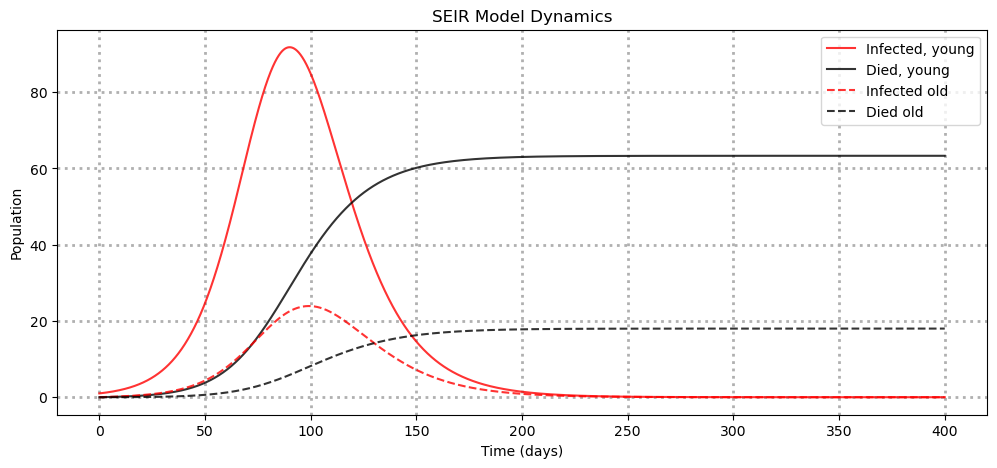

In [138]:
Y_t = solmat.y.reshape(2,4,len(t))

S_plot, I_plot, R_plot, D_plot = Y_t[0]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
plt.figure(figsize=(12,5))
#plt.plot(t, S_plot, 'b', label='Susceptible, young', alpha=0.8)
plt.plot(t, I_plot, 'r', label='Infected, young', alpha=0.8)
#plt.plot(t, R_plot, 'g', label='Recovered, young', alpha=0.8)
plt.plot(t, D_plot, 'k', label='Died, young', alpha=0.8)

S_plot, I_plot, R_plot, D_plot = Y_t[1]

# plot the data on four separate curves for S(t), E(t), I(t) and R(t)
#plt.figure(figsize=(20,11))
#plt.plot(t, S_plot, 'b--', label='Susceptible old', alpha=0.8)
plt.plot(t, I_plot, 'r--', label='Infected old', alpha=0.8)
#plt.plot(t, R_plot, 'g--', label='Recovered old', alpha=0.8)
plt.plot(t, D_plot, 'k--', label='Died old', alpha=0.8)
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")

# 2D version fitting

Going to generate data from the 2D version and fit that. 

Number of populations = 2

Day of start of infection = 0

 Starting vector = 
 [[999   1   0   0]
 [500   0   0   0]]

Parameters:
 beta_vector =  [0.22 0.15]
 gamma = 0.95,
 delta = 0.013,

 theta_matrix = 
 [[0.88 0.12]
 [0.12 0.88]]


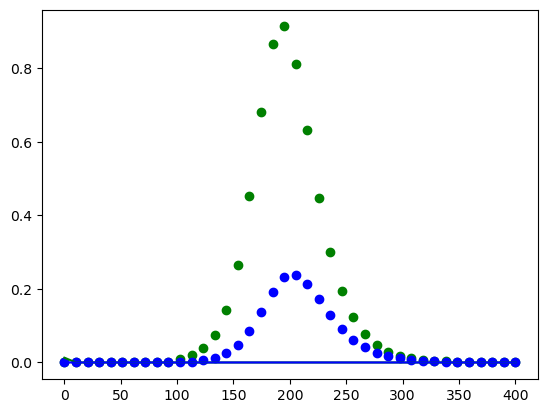

In [180]:
Y_day_0_of_infection = np.array([[999, 1, 0, 0],
                                 [500, 0, 0, 0]])

beta_vector_0 = np.array([0.22, 0.15])

gamma_0, delta_0 = 0.95, 0.013

# the coupling matrix between the boxes. 
theta_cross_0 = 0.12
theta_matrix_0 = np.array([[1.0-theta_cross_0, theta_cross_0],
                         [theta_cross_0, 1-theta_cross_0]])

day_of_start_0 = 0

print("Number of populations = {}\n".format(len(beta_vector_0)))
print("Day of start of infection = {}\n".format(day_of_start_0))
print(" Starting vector = \n",Y_day_0_of_infection)
print("\nParameters:\n beta_vector = ",beta_vector_0)
print(" gamma = {},\n delta = {},\n".format(gamma_0, delta_0))
print(" theta_matrix = \n",theta_matrix_0)


plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], color='green',label='Sparse Young Deaths per Day')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], color='blue',label='Sparse Old Deaths per Day')

initial_guess_derivs = compute_derivs_per_day(t_sparse,
                           day_of_start_0,
                           Y_day_0_of_infection,
                           beta_vector_0,
                           gamma_0,
                           delta_0,
                           theta_matrix_0)

plt.plot(t_sparse, initial_guess_derivs[0,3,:], color='green', label='Young initial guess')
plt.plot(t_sparse, initial_guess_derivs[1,3,:], color='blue', label='Old initial guess')

# Training the model

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SIRD model on NZ data. 



In [146]:
NZ_death_data = pd.read_csv('deaths_by_age_and_date.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,'0-19']+NZ_death_data.loc[:,'20-49']+NZ_death_data.loc[:,'50+']
NZ_death_data

,date_death,military_binary,0-19,20-49,50+,Total
0,1918-09-01 00:00:00,Y,0,1,0,1
1,1918-09-02 00:00:00,Y,0,6,0,6
2,1918-09-03 00:00:00,Y,0,4,0,4
3,1918-09-04 00:00:00,Y,0,23,0,23
4,1918-09-05 00:00:00,Y,1,15,0,16
...,...,...,...,...,...,...
147,1919-02-22 00:00:00,Y,0,2,0,2
148,1919-02-23 00:00:00,Y,0,1,0,1
149,1919-02-24 00:00:00,Y,0,2,0,2
150,1919-02-25 00:00:00,Y,0,3,0,3


In [147]:
N_0_19 , N_20_49, N_50p =  455502, 481145, 161536  # from age census data 1916
N_T = N_0_19 + N_20_49 + N_50p
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 481145 ,
Number of 50+:     161536,
     Total number :   1098183


In [148]:
# the SEIR model differential equations
def deriv_1D(t, y, beta, gamma, delta, N):
    S, I, R, D = y
    dSdt = -beta * S * I / (N-D)
    dIdt = -dSdt - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

def fitting_function_1_compartment(dates,
                                   date_of_first_infection,
                                   beta,
                                   gamma,
                                   delta):

    Y_day_0_of_infection = np.array([1098182, 1, 0, 0])
        
    num_population = 1098183
    
    # Now we use scipy to solve the system of differential equations
    solmat = solve_ivp(deriv_1D, 
                   [min(t), max(t)], 
                   Y_day_0_of_infection, 
                   args=(beta, gamma, delta, num_population), 
                   dense_output=True)

    dates_after_start = dates[dates >= date_of_first_infection]-date_of_first_infection
    dates_before_start = dates[dates < date_of_first_infection]
    
    total_compartments_eval = np.concatenate([np.zeros((4,len(dates_before_start))) , solmat.sol(dates_after_start)], axis=1)

    my_derivs = deriv_1D(x, total_compartments_eval, beta, gamma, delta, num_population)
    
    return my_derivs[3]

In [149]:
    
# the contact rate, beta, incubation rate, sigma, and mean recovery rate, gamma
beta_0 = 0.95

gamma_0, delta_0 = 0.7, 0.01

Y_day_0_of_infection = np.array([1098182, 1, 0, 0])

day_of_first_infection_0 = 30

num_population = 1098183

print("Starting parameters are:\n   beta = {},\n   gamma = {},\n   delta = {},\n   day zero = {}".format(beta_0,
                                                                                                         gamma_0, 
                                                                                                         delta_0,
                                                                                                         day_of_first_infection_0))

Starting parameters are:
   beta = 0.95,
   gamma = 0.7,
   delta = 0.01,
   day zero = 30


In [150]:
dummy = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummymin = min(dummy)
x = dummy.apply(lambda l: l - dummymin).dt.days

y = NZ_death_data.sort_values('date_death')['Total']

sigma = np.maximum(np.zeros(y.shape),np.sqrt(y))

(4, 152)


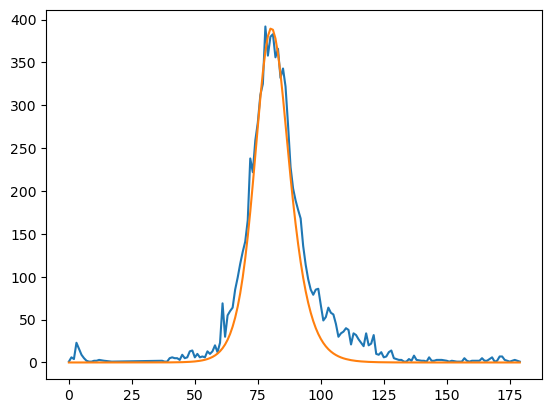

In [151]:
solmat = solve_ivp(deriv_1D, 
                   [min(x), max(x)], 
                   Y_day_0_of_infection, 
                   args=(beta_0, gamma_0, delta_0, num_population), 
                   dense_output=True)
dates_after_start = x[x >= day_of_first_infection_0]-day_of_first_infection_0
dates_before_start = x[x < day_of_first_infection_0]

total_compartments_eval = np.concatenate([np.zeros((4,len(dates_before_start))) , solmat.sol(dates_after_start)], axis=1)
print(total_compartments_eval.shape)

my_derivs = deriv_1D(x, total_compartments_eval, beta_0, gamma_0, delta_0, num_population)

plt.plot(x, y, label='Total deaths')
plt.plot(x, my_derivs[3], label='SIRD first guess')


In [152]:
sol_curve = curve_fit(fitting_function_1_compartment,
                      x,
                      y,
                      p0 = [day_of_first_infection_0, beta_0, gamma_0, delta_0],
                      sigma=sigma,
                      absolute_sigma=True, 
                     bounds=([0,0,0,0],[70,10.0,10.0,0.1]))

day_of_first_infection_fit, beta_fit, gamma_fit, delta_fit = sol_curve[0] 
delta_day, delta_beta, delta_gamma, delta_delta = np.sqrt(np.diag(sol_curve[1]))
print("Final fitted parameters are:")
print("   day zero = {:.2g} +- {:.1g},".format(day_of_first_infection_fit, delta_day))
print("   beta     = {:.3g} +- {:.1g},".format(beta_fit, delta_beta))
print("   gamma    = {:.3g} +- {:.1g},".format(gamma_fit, delta_gamma)) 
print("   delta    = {:.3g} +- {:.1g},\n".format(delta_fit,delta_delta))
print("        where the quoted uncertainty is 1 estimated standard deviation.\n")                                                                                                                                                                                                                                               ,
                                                                                                                                                                                                                                              
sol_curve



Final fitted parameters are:
   day zero = 18 +- 1,
   beta     = 0.377 +- 0.004,
   gamma    = 0.142 +- 0.007,
   delta    = 0.00124 +- 8e-05,

        where the quoted uncertainty is 1 estimated standard deviation.



(array([1.76715610e+01, 3.76611224e-01, 1.41825948e-01, 1.23596200e-03]),
 array([[ 1.05988291e+00,  8.37017258e-04, -4.75141672e-03,
         -5.55665722e-05],
        [ 8.37017258e-04,  1.75268527e-05,  1.75636243e-05,
          1.83499872e-07],
        [-4.75141672e-03,  1.75636243e-05,  4.86252936e-05,
          5.40733033e-07],
        [-5.55665722e-05,  1.83499872e-07,  5.40733033e-07,
          6.20644384e-09]]))

In [153]:

solmat = solve_ivp(deriv_1D, 
                   [min(x), max(x)], 
                   Y_day_0_of_infection, 
                   args=(beta_fit, gamma_fit, delta_fit, num_population), 
                   dense_output=True)
dates_after_start = x[x >= day_of_first_infection_fit]-day_of_first_infection_fit
dates_before_start = x[x < day_of_first_infection_fit]

total_compartments_eval = np.concatenate([np.zeros((4,len(dates_before_start))) , solmat.sol(dates_after_start)], axis=1)
print(total_compartments_eval.shape)

my_derivs = deriv_1D(x, total_compartments_eval, beta_fit, gamma_fit, delta_fit, num_population)

(4, 152)


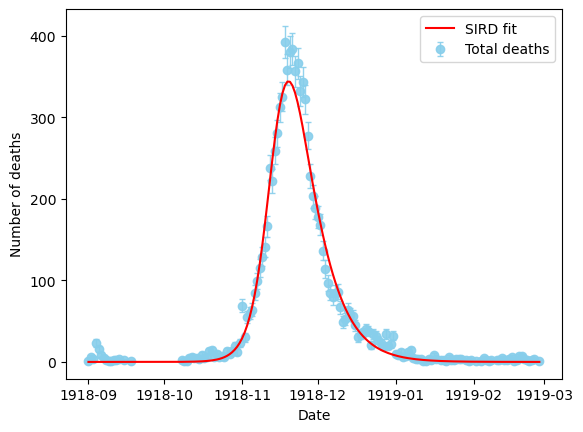

In [154]:
xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
plt.errorbar(xplot, y, sigma, linewidth=0.0, elinewidth=1.0, capsize=2.0, label='Total deaths', marker='o', color='skyblue', alpha=0.9)
plt.plot(xplot, my_derivs[3], label='SIRD fit', color='red', zorder=10)
plt.xlabel('Date')
plt.ylabel('Number of deaths')
plt.legend()

# Fitting the matrix version

Text(0.5, 1.0, 'First Guess')

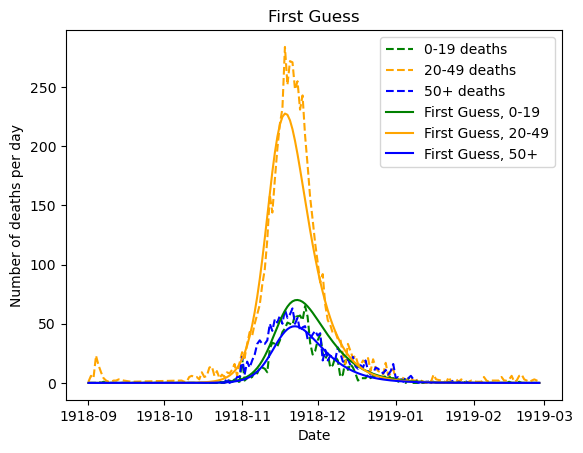

In [155]:
Y_day_0_of_infection = np.array([[455502, 0, 0, 0],
                                 [481145, 1, 0, 0],
                                 [161536, 0, 0, 0]])

gamma_0, delta_0 = 0.18, 0.0022
beta_vector_0 = [0.037, 0.577, 0.277]
theta_cross_0 = 0.1
theta_matrix_0 = np.array([[1-2*theta_cross_0, theta_cross_0, theta_cross_0],
                             [theta_cross_0, 1-2*theta_cross_0, theta_cross_0],
                             [theta_cross_0, theta_cross_0 , 1-2*theta_cross_0]])

day_of_first_infection_0 = 23
dates_after_start = x[x >= day_of_first_infection_0]-day_of_first_infection_0
dates_before_start = x[x < day_of_first_infection_0]


solmat = solve_ivp(deriv_matrix, 
                   [min(x), max(x)], 
                   Y_day_0_of_infection.flatten(), 
                   args=(beta_vector_0, gamma_0, delta_0, theta_matrix_0), 
                   t_eval=dates_after_start)

total_compartments_eval = solmat.y.reshape(*Y_day_0_of_infection.shape,len(dates_after_start)).transpose((2,0,1))

my_derivs = []
for day in range(total_compartments_eval.shape[0]):
    my_derivs.append(deriv_matrix(x, total_compartments_eval[day], beta_vector_0, gamma_0, delta_0, theta_matrix_0).reshape(Y_day_0_of_infection.shape))

my_plotting_derivs = np.concatenate([np.zeros((*Y_day_0_of_infection.shape,len(dates_before_start))), np.array(my_derivs).transpose((1,2,0))],axis=2)


xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])

y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']

plt.plot(xplot, y_young, 'g--', label='0-19 deaths')
plt.plot(xplot, y_mid, '--', color='orange', label='20-49 deaths')
plt.plot(xplot, y_old, 'b--', label='50+ deaths')


S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[0]
plt.plot(xplot, D_plot, 'g-', label='First Guess, 0-19')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[1]
plt.plot(xplot, D_plot, color='orange', label='First Guess, 20-49')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[2]
plt.plot(xplot, D_plot, color='blue',label='First Guess, 50+')
plt.legend()
plt.xlabel('Date'), plt.ylabel('Number of deaths per day')
plt.title('First Guess')
#my_plotting_derivs.shape

In [177]:
def compute_derivs_per_day(dates,
                           date_of_first_infection,
                           Y_day_0_of_infection,
                           beta_vector,
                           gamma,
                           delta,
                           theta_matrix):
    
    dates_after_start = dates[dates >= date_of_first_infection]-date_of_first_infection
    dates_before_start = dates[dates < date_of_first_infection]
    
    # Now we use scipy to solve the system of differential equations
    solmat = solve_ivp(deriv_matrix, 
                   [min(dates_after_start), max(dates_after_start)], 
                   Y_day_0_of_infection.flatten(), 
                   args=(beta_vector, gamma, delta, theta_matrix), 
                   dense_output=True)
    
    
    total_compartments_eval = solmat.sol(dates_after_start).reshape(*Y_day_0_of_infection.shape,len(dates_after_start)).transpose((2,0,1))
    
    derivs_post_day_0 = np.zeros(total_compartments_eval.shape)
    for i, y_day in enumerate(total_compartments_eval):
        derivs_post_day_0[i] = deriv_matrix(dates_after_start, 
                                            y_day, 
                                            beta_vector, 
                                            gamma, 
                                            delta, 
                                            theta_matrix).reshape(Y_day_0_of_infection.shape)

    derivs_for_all_days = np.concatenate([np.zeros((len(dates_before_start),*Y_day_0_of_infection.shape)), np.array(derivs_post_day_0)],
                                         axis=0).transpose((1,2,0))    
    
    return derivs_for_all_days # Return only the death data

def fitting_function_matrix(dates,
                            date_of_first_infection,
                            beta_young,
                            beta_mid,
                            beta_old,
                            gamma,
                            delta,
                            theta_cross):

    
    Y_day_0_of_infection = np.array([[455502, 1, 0, 0],
                                     [481145, 1, 0, 0],
                                     [161536, 1, 0, 0]])
    
    beta_vector = [beta_young, beta_mid, beta_old]
    
    theta_matrix = np.array([[1-2*theta_cross, theta_cross, theta_cross],
                             [theta_cross, 1-2*theta_cross, theta_cross],
                             [theta_cross, theta_cross , 1-2*theta_cross]])

    derivs_for_all_days = compute_derivs_per_day(dates,
                                  date_of_first_infection,
                                  Y_day_0_of_infection,
                                  beta_vector,
                                  gamma,
                                  delta,
                                  theta_matrix)

    return derivs_for_all_days[:,3,:]
    

def error_function(params, dates, y_data, sigma) -> float:
    
    y_fit = fitting_function_matrix(dates, *params )

    xi = (y_fit - y_data)*(y_fit - y_data) / (sigma*sigma) 

    return np.sqrt(xi.sum() / len(xi))

In [157]:
y_data_shaped = np.array([y_young, y_mid, y_old])
y_data = y_data_shaped

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

padded_x = np.broadcast_to(x, (3,152)).flatten()

In [158]:
[day_of_first_infection_0, *beta_vector_0, gamma_0, delta_0, theta_cross_0]

[23, 0.037, 0.577, 0.277, 0.18, 0.0022, 0.1]

In [168]:
from scipy.optimize import minimize

opt = minimize(error_function, 
               [day_of_first_infection_0, *beta_vector_0, gamma_0, delta_0, theta_cross_0],
               args = (x, y_data, sigma_data),
               bounds=[(15,30),(0.00,2.0),(0.05,2.0),(0.00,2.0),(0.01,2.0),(0.0001,0.1),(0.0,1.0/3.0)],
               tol=1e-12,
               method='Nelder-Mead',
               options={'maxiter':3000})
opt

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 22.59453208086518
             x: [ 2.300e+01  3.700e-02  5.770e-01  2.770e-01  1.800e-01
                  2.200e-03  1.000e-01]
           nit: 42
          nfev: 377
 final_simplex: (array([[ 2.300e+01,  3.700e-02, ...,  2.200e-03,
                         1.000e-01],
                       [ 2.300e+01,  3.700e-02, ...,  2.200e-03,
                         1.000e-01],
                       ...,
                       [ 2.300e+01,  3.700e-02, ...,  2.200e-03,
                         1.000e-01],
                       [ 2.300e+01,  3.700e-02, ...,  2.200e-03,
                         1.000e-01]], shape=(8, 7)), array([ 2.259e+01,  2.259e+01,  2.259e+01,  2.259e+01,
                        2.259e+01,  2.259e+01,  2.259e+01,  2.259e+01]))

In [169]:
day_of_first_infection_fit, beta_fit_young, beta_fit_mid, beta_fit_old, gamma_fit, delta_fit, theta_cross_fit = opt.x
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_y   = {:.3g} ,".format(beta_fit_young))
print("   beta_m   = {:.3g} ,".format(beta_fit_mid))
print("   beta_o   = {:.3g} ,".format(beta_fit_old))
print("   gamma    = {:.3g} ,".format(gamma_fit)) 
print("   delta    = {:.3g} ,".format(delta_fit))
print("   theta    = {:.3g} ,\n".format(theta_cross_fit))
print("        where the quoted uncertainty is 1 estimated standard deviation.\n")   

Final fitted parameters are:
   day zero = 23 ,
   beta_y   = 0.037 ,
   beta_m   = 0.577 ,
   beta_o   = 0.277 ,
   gamma    = 0.18 ,
   delta    = 0.0022 ,
   theta    = 0.1 ,

        where the quoted uncertainty is 1 estimated standard deviation.



(3, 4, 152)


Text(0.5, 1.0, 'Fit')

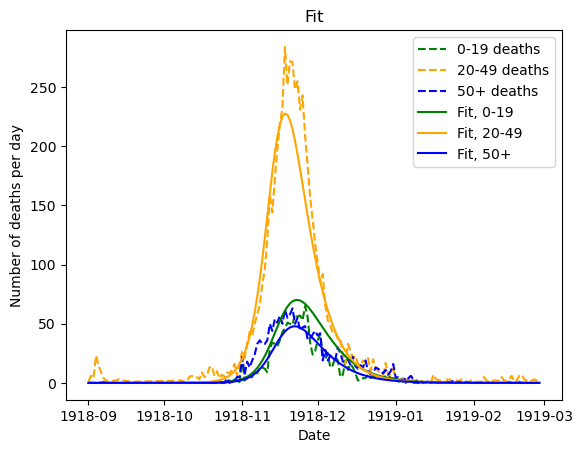

In [166]:
beta_vector_fit = [beta_fit_young, beta_fit_mid, beta_fit_old]
theta_matrix_fit = np.array([[1-2*theta_cross_fit, theta_cross_fit, theta_cross_fit],
                             [theta_cross_fit, 1-2*theta_cross_fit, theta_cross_fit],
                             [theta_cross_fit, theta_cross_fit , 1-2*theta_cross_fit]])

dates_after_start = x[x >= day_of_first_infection_fit]-day_of_first_infection_fit
dates_before_start = x[x < day_of_first_infection_fit]


solmat = solve_ivp(deriv_matrix, 
                   [min(x), max(x)], 
                   Y_day_0_of_infection.flatten(), 
                   args=(beta_vector_fit, gamma_fit, delta_fit, theta_matrix_fit), 
                   t_eval=dates_after_start)

total_compartments_eval = solmat.y.reshape(*Y_day_0_of_infection.shape,len(dates_after_start)).transpose((2,0,1))

my_derivs = []
for day in range(total_compartments_eval.shape[0]):
    my_derivs.append(deriv_matrix(x, total_compartments_eval[day], beta_vector_fit, gamma_fit, delta_fit, theta_matrix_fit).reshape(Y_day_0_of_infection.shape))

my_plotting_derivs = np.concatenate([np.zeros((*Y_day_0_of_infection.shape,len(dates_before_start))), np.array(my_derivs).transpose((1,2,0))],axis=2)

print(my_plotting_derivs.shape)

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])

y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']

plt.plot(xplot, y_young, 'g--', label='0-19 deaths')
plt.plot(xplot, y_mid, '--', color='orange', label='20-49 deaths')
plt.plot(xplot, y_old, 'b--', label='50+ deaths')


S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[0]
plt.plot(xplot, D_plot, 'g', label='Fit, 0-19')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[1]
plt.plot(xplot, D_plot, color='orange',label='Fit, 20-49')
S_plot, I_plot, R_plot, D_plot = my_plotting_derivs[2]
plt.plot(xplot, D_plot, color='blue',label='Fit, 50+')
plt.legend()
plt.xlabel('Date'), plt.ylabel('Number of deaths per day')
plt.title('Fit')
#my_plotting_derivs.shape

In [167]:
sol_curve = curve_fit(fitting_function_matrix,
                      x,
                      y_data,
                      p0 = [day_of_first_infection_0, *beta_vector_0, gamma_0, delta_0, theta_cross_0],
                      sigma=sigma_data,
                      absolute_sigma=True,
                      bounds=([0.0,0.01,0.01,0.01,0.01,0.0001,0.01],[50.0,1.0,1.0,1.0,0.9,0.1,1./3]))

day_of_first_infection_fit, beta_fit_young, beta_fit_mid, beta_fit_old, gamma_fit, delta_fit, theta_cross_fit = sol_curve[0] 
delta_day, delta_beta_young, delta_beta_mid, delta_beta_old, delta_gamma, delta_delta, delta_theta_cross = np.sqrt(np.diag(sol_curve[1]))
print("Final fitted parameters are:")
print("   day zero = {:.2g} +- {:.1g},".format(day_of_first_infection_fit, delta_day))
print("   beta_y   = {:.3g} +- {:.1g},".format(beta_fit_young, delta_beta_young))
print("   beta_m   = {:.3g} +- {:.1g},".format(beta_fit_mid, delta_beta_mid))
print("   beta_o   = {:.3g} +- {:.1g},".format(beta_fit_old, delta_beta_old))
print("   gamma    = {:.3g} +- {:.1g},".format(gamma_fit, delta_gamma)) 
print("   delta    = {:.3g} +- {:.1g},".format(delta_fit,delta_delta))
print("   theta    = {:.3g} +- {:.1g},\n".format(theta_cross_fit,delta_theta_cross))
print("        where the quoted uncertainty is 1 estimated standard deviation.\n")                                                                                                                                                                                                                                               ,
                                                                                                                                                                                                                                              
sol_curve

ValueError: `sigma` has incorrect shape.